## Apply the time seres analysis per each x, y location (pixel) within a single Equi7grid tile

In [35]:
import numpy as np
import os, osr, glob
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
import pandas as pd
import xarray as xr
import rioxarray
import zarr
# import TUW packages
from yeoda.products.preprocessed import SIG0DataCube
from geopathfinder.naming_conventions.yeoda_naming import YeodaFilename
#
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
# import my aux functions
from auxilary_ts_tools_mm import plot_TS_fromPandaSeres, features_from_S1_TS, features_as_xrrray_ufunc

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Specify the folders with a S1 datacube (a 300x300 m<sup>2</sup> Equi7Tile)

In [2]:
tile_dir1_path = r'/project/return/Share/EODC_SA020M/V01R01/E078N066T3'
tile_dir2_path = r'/project/return/Share/EODC_SA020M/V1M0R1/E078N066T3'
#tile_dir1_path = r'/project/return/Share/EODC_SA020M/V01R01/E078N060T3'
#tile_dir2_path = r'/project/return/Share/EODC_SA020M/V1M0R1/E078N060T3'
# specify other parameters:
dimensions=['time', 'band', 'extra_field', 'sensor_field']
#
filepaths1 = glob.glob(os.path.join(tile_dir1_path,'*.tif'))
filepaths2 = glob.glob(os.path.join(tile_dir2_path,'*.tif'))

Get the lists of all tiles in the two folders with data and check if they are identical:

In [3]:
tile_names1 = [os.path.basename(aa) for aa in glob.glob(r'/project/return/Share/EODC_SA020M/V01R01/*')]
tile_names2 = [os.path.basename(aa) for aa in glob.glob(r'/project/return/Share/EODC_SA020M/V1M0R1/*')]

In [4]:
len(tile_names1)

107

In [5]:
len(tile_names2)

106

The tile that is missing in EODC_SA020M/V1M0R1

In [6]:
tile_names1[np.where(~np.isin(tile_names1, tile_names2))[0][0]]

'E078N078T3'

Read the datacube:

In [7]:
sig0_dc1 = SIG0DataCube(filepaths=filepaths1, dimensions=dimensions, filename_class=YeodaFilename, sres=20, continent='SA')
sig0_dc2 = SIG0DataCube(filepaths=filepaths2, dimensions=dimensions, filename_class=YeodaFilename, sres=20, continent='SA')
# get info:
sig0_dc2.inventory[dimensions].head(5)

,time,band,extra_field,sensor_field,var_name,tile_name
0,2016-11-26 09:22:09,VH,D039,S1AIWGRDH,SIG0,E078N066T3
1,2018-01-20 09:22:44,VH,D039,S1AIWGRDH,SIG0,E078N066T3
2,2017-05-20 09:14:52,VH,D141,S1AIWGRDH,SIG0,E078N066T3
3,2017-04-14 09:13:55,VH,D141,S1AIWGRDH,SIG0,E078N066T3
4,2017-11-21 09:22:21,VH,D039,S1AIWGRDH,SIG0,E078N066T3


Filter by date:

In [8]:
toi_start, toi_end = datetime(2017, 1, 1), datetime(2021, 1, 1)
sig0_dc1 = sig0_dc1.filter_by_dimension([(toi_start, toi_end)], [(">=", "<")], name="time", inplace=True)
sig0_dc2 = sig0_dc2.filter_by_dimension([(toi_start, toi_end)], [(">=", "<")], name="time", inplace=True)

Select bands:

In [9]:
sig0_vv_dc1 = sig0_dc1.filter_by_dimension('VV', name='band')
sig0_vh_dc1 = sig0_dc1.filter_by_dimension('VH', name='band')
#
sig0_vv_dc2 = sig0_dc2.filter_by_dimension('VV', name='band')
sig0_vh_dc2 = sig0_dc2.filter_by_dimension('VH', name='band')

Merge and sort the datacubes:

In [10]:
sig0_vv_dc = sig0_vv_dc1.unite(sig0_vv_dc2)
sig0_vv_dc = sig0_vv_dc.sort_by_dimension('time', ascending=True)
#
sig0_vh_dc = sig0_vh_dc1.unite(sig0_vh_dc2)
sig0_vh_dc = sig0_vh_dc.sort_by_dimension('time', ascending=True)
#
sig0_vv_dc.inventory

,filepath,time,band,extra_field,sensor_field,var_name,tile_name
732,/project/return/Share/EODC_SA020M/V1M0R1/E078N...,2017-01-01 09:22:07,VV,D039,S1AIWGRDH,SIG0,E078N066T3
452,/project/return/Share/EODC_SA020M/V1M0R1/E078N...,2017-01-01 09:22:32,VV,D039,S1AIWGRDH,SIG0,E078N066T3
537,/project/return/Share/EODC_SA020M/V1M0R1/E078N...,2017-01-01 09:22:57,VV,D039,S1AIWGRDH,SIG0,E078N066T3
630,/project/return/Share/EODC_SA020M/V1M0R1/E078N...,2017-01-08 09:13:54,VV,D141,S1AIWGRDH,SIG0,E078N066T3
782,/project/return/Share/EODC_SA020M/V1M0R1/E078N...,2017-01-08 09:14:19,VV,D141,S1AIWGRDH,SIG0,E078N066T3
...,...,...,...,...,...,...,...
31,/project/return/Share/EODC_SA020M/V01R01/E078N...,2020-12-23 09:23:29,VV,D039,S1A,SIG0,E078N066T3
87,/project/return/Share/EODC_SA020M/V01R01/E078N...,2020-12-29 09:22:39,VV,D039,S1B,SIG0,E078N066T3
319,/project/return/Share/EODC_SA020M/V01R01/E078N...,2020-12-30 09:14:26,VV,D141,S1A,SIG0,E078N066T3
222,/project/return/Share/EODC_SA020M/V01R01/E078N...,2020-12-30 09:14:51,VV,D141,S1A,SIG0,E078N066T3


Specify indexing for looping trough individual chunks within the Equi7grid tile:

In [11]:
# read a raster to get the size of x and y coordinates:
#single_tif_ds = xr.open_dataset(sig0_vv_dc.inventory.filepath[20], engine="rasterio") 
single_tif_ds = xr.open_dataset(sig0_vv_dc.inventory.filepath[20], engine="rasterio") 
#
#my_file_path = r'/project/return/Share/EODC_SA020M/V1M0R1/E078N060T3/SIG0_20180807T091643__VV_D141_E078N060T3_SA020M_V1M0R1_S1AIWGRDH.tif'
#
#single_tif_ds = xr.open_dataset(my_file_path, engine="rasterio") 

In [12]:
single_tif_ds

<xarray.Dataset>
Dimensions:      (band: 1, x: 15000, y: 15000)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 7.8e+06 7.8e+06 7.8e+06 ... 8.1e+06 8.1e+06 8.1e+06
  * y            (y) float64 6.9e+06 6.9e+06 6.9e+06 ... 6.6e+06 6.6e+06 6.6e+06
    spatial_ref  int64 ...
Data variables:
    band_data    (band, y, x) float32 ...

In [13]:
my_chunk_size = 1000
#
steps_row = np.arange(0, len(single_tif_ds.x)/my_chunk_size).astype(int)
steps_col = np.arange(0, len(single_tif_ds.y)/my_chunk_size).astype(int)

In [14]:
steps_row

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

Load data 

In [15]:
sig0_vv_dc_chunk1 = sig0_vv_dc.load_by_pixels(14*1000, 14*1000, row_size=1000, col_size=1000, dtype='xarray')
sig0_vh_dc_chunk1 = sig0_vv_dc.load_by_pixels(14*1000, 14*1000, row_size=1000, col_size=1000, dtype='xarray')

Get info

In [16]:
print(sig0_vv_dc_chunk1)

<xarray.Dataset>
Dimensions:  (time: 818, y: 1000, x: 1000)
Coordinates:
  * time     (time) datetime64[ns] 2017-01-01T09:22:07 ... 2020-12-30T09:15:16
  * y        (y) float64 6.62e+06 6.62e+06 6.62e+06 ... 6.6e+06 6.6e+06 6.6e+06
  * x        (x) float64 8.08e+06 8.08e+06 8.08e+06 ... 8.1e+06 8.1e+06 8.1e+06
Data variables:
    1        (time, y, x) float64 nan nan nan nan ... -72.7 -66.9 -84.3 -80.1


Get the in-memory size 

In [17]:
print('Datacube size in memory is:', np.round(sig0_vv_dc_chunk1.nbytes/(1024*1024), 1), 'MB')

Datacube size in memory is: 6240.9 MB


Rename the variavle

In [18]:
sig0_vv_dc_chunk1 = sig0_vv_dc_chunk1.rename({'1':'sig0_vv'})

In [19]:
sig0_vh_dc_chunk1 = sig0_vh_dc_chunk1.rename({'1':'sig0_vh'})

Plot a time seres and inspect values:

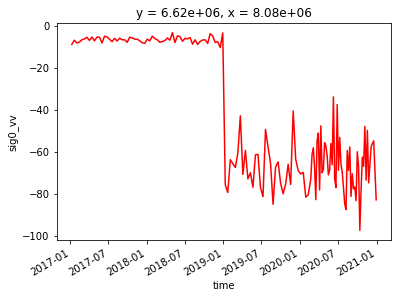

In [20]:
sig0_vv_dc_chunk1.sig0_vv.isel(x=0, y=0).dropna(dim='time').plot(linestyle='-', color='r')

In [ ]:
sig0_vh_dc_chunk1.sig0_vh.isel(x=0, y=0).dropna(dim='time').plot(linestyle='-', color='r')

Rescale the data in 2019 and 2020

In [ ]:
sig0_vv_dc_chunk1['sig0_vv'].loc[slice('2019-1-1','2021-1-1'), :, :] = sig0_vv_dc_chunk1.sel(time=slice('2019-1-1','2021-1-1')).apply(lambda x: np.round(x/10.,1)).sig0_vv.values
sig0_vh_dc_chunk1['sig0_vh'].loc[slice('2019-1-1','2021-1-1'), :, :] = sig0_vh_dc_chunk1.sel(time=slice('2019-1-1','2021-1-1')).apply(lambda x: np.round(x/10.,1)).sig0_vh.values

In [ ]:
sig0_vv_dc_chunk1.sig0_vv.isel(x=0, y=0).dropna(dim='time').plot(linestyle='-', color='r')

In [ ]:
sig0_vh_dc_chunk1.sig0_vh.isel(x=0, y=0).dropna(dim='time').plot(linestyle='-', color='r')

Convert to pandas seres and plot

In [ ]:
sig0_vv_ts = sig0_vv_dc_chunk1.sig0_vv.isel(x=0, y=0).dropna(dim='time').to_series()

In [ ]:
my_xticks = pd.date_range(datetime(2017,1,1), datetime(2021,1,1), freq='YS')
sig0_vv_ts.plot(style='ro-', xticks=my_xticks, grid=True, figsize=(14,4), legend=True, xlabel='Time', ylabel='Bacscatter Intensity [dB]')

Round the time and resample to 6 day TS:

In [ ]:
sig0_vv_ts.index = sig0_vv_ts.index.round('D')
#
sig0_vv_ts_6d = sig0_vv_ts.resample('6D').interpolate(method='linear')

In [ ]:
sig0_vv_ts_6d.plot(style='bo-',grid=True, figsize=(14,4), legend=True, xlabel='Time', ylabel='Bacscatter Intensity [dB]')

In [ ]:
plot_TS_fromPandaSeres(sig0_vv_ts_6d)

In [ ]:
myFeatures_v2 = features_from_S1_TS(sig0_vv_ts_6d)
myFeatures_v2

## xarray-approach: apply the time-seres analysis per each x, y location in xarray

Prepare timestamps

In [21]:
ts_time_stamps = sig0_vv_dc_chunk1['sig0_vv'][:,0, 0].time.values

Get features per each pixel

In [22]:
#%%timeit
dist_out = xr.apply_ufunc(features_as_xrrray_ufunc, 
                          sig0_vh_dc_chunk1['sig0_vh'],
                          ts_time_stamps,
                          input_core_dims=[["time"], []],
                          output_core_dims=[["features"]]
                         )

In [ ]:
#%%timeit
dist_out = xr.apply_ufunc(features_as_xrrray_ufunc, 
                          sig0_vv_dc_chunk1['sig0_vv'],
                          ts_time_stamps,
                          input_core_dims=[["time"], []],
                          output_core_dims=[["features"]]
                         )

In [ ]:
# timeit, 200x200 pixels: 4min 49s ± 4.23 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
# timeit, 100x100 pixels: 1min 13s ± 451 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
# timeit, 50x50 pixel: 18.6 s ± 91.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
# timeit, 10x10 pixels: 741 ms ± 2.57 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

In [23]:
# convert output to dataset
dist_out_ds = dist_out.to_dataset(dim='features')

In [24]:
dist_out_ds = dist_out_ds.rename({0:'exception_label', 1:'ref_mean', 2:'error_margin',
                                  3:'num_of_segments', 4:'TS_end_flag', 5:'TS_end_flag_long', 6:'TS_end_mag',
                                  7:'seg_id', 8:'seg_size', 9:'max_mag', 10:'max_mag_date', 11:'t_pre', 12:'t_post', 13:'t_total',
                                  14:'max_mag_org', 15:'max_mag_org_date', 16:'t_mag_org',
                                  17:'seg2_size'})

In [25]:
dist_out_ds

<xarray.Dataset>
Dimensions:           (y: 1000, x: 1000)
Coordinates:
  * y                 (y) float64 6.62e+06 6.62e+06 6.62e+06 ... 6.6e+06 6.6e+06
  * x                 (x) float64 8.08e+06 8.08e+06 8.08e+06 ... 8.1e+06 8.1e+06
Data variables: (12/18)
    exception_label   (y, x) object 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    ref_mean          (y, x) object -6.643 -8.257 -7.753 ... -7.911 -7.923
    error_margin      (y, x) object 0.9221 1.184 1.237 ... 1.229 0.9568 0.9053
    num_of_segments   (y, x) object 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
    TS_end_flag       (y, x) object 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
    TS_end_flag_long  (y, x) object 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
    ...                ...
    t_post            (y, x) object 66 402 107 102 414 ... 504 510 480 474 408
    t_total           (y, x) object 708 708 708 708 708 ... 708 708 708 708 708
    max_mag_org       (y, x) object 90.86 105.8 97.95 ... 98.76 88.39 86.48
    max_mag_org_date  (y, x) object 2020-10-13T09:14:34 ... 2019-08-14T09:15:09
    t_mag_org         (y, x) object 12 282 17 -6 18 -49 ... -13 449 6 -24 6 -72
    seg2_size         (y, x) object nan nan nan nan nan ... nan nan nan nan nan

In [26]:
print('Datacube size in memory is:', np.round(dist_out_ds.nbytes/(1024*1024), 1), 'MB')

Datacube size in memory is: 137.3 MB


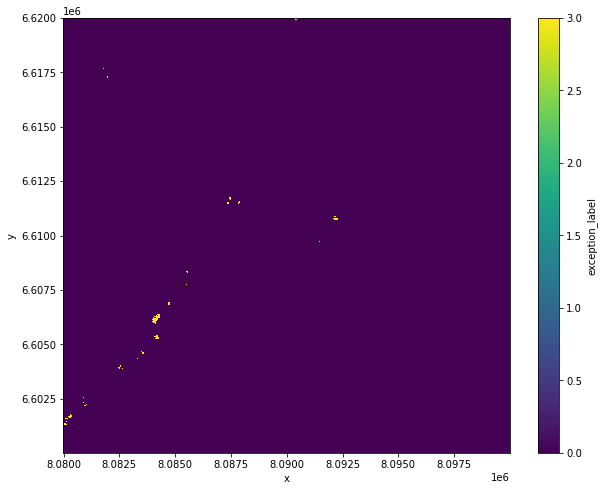

In [27]:
#d plotting:
#dist_out_ds.seg_size.astype('float').plot()
feature_da = dist_out_ds.exception_label.astype('int')
feature_da.plot(figsize=(10, 8))

get a list of row and columnns where the exception label is 0

In [28]:
aa = np.column_stack(np.where(feature_da.where(feature_da == 0).values))

In [ ]:
aa[20000, :]

### Export

In [31]:
type(dist_out_ds)

xarray.core.dataset.Dataset

In [ ]:
dist_out_ds.to_zarr(os.path.join(r'/home/return-mmilenkovic/', 'test_chunk_export_vh.zarr'), 'w')

In [ ]:
dist_out_ds.to_netcdf(os.path.join(r'/home/return-mmilenkovic/', 'test_chunk_export_vh.nc'))

## Check the output

In [ ]:
#my_out = xr.open_dataset("/home/return-mmilenkovic/E078N066T3_1_1_100_VH.nc")
#my_out = xr.open_dataset("/project/return/Share/mm/S1_SA_output/E078N066T3_10_7_1000_VH.nc")
my_out = xr.open_dataset("E078N066T3_14_14_1000_VH.nc")

In [ ]:
my_out

In [ ]:
feature_da = my_out.max_mag.astype('float64')
feature_da.plot(figsize=(10, 8))

In [ ]:
np.nanmedian(my_out.max_mag.values.flatten())